In [ ]:
import requests as r
import json
import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt

import numpy as np
from matplotlib.dates import AutoDateLocator

from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
#import keras_tuner as kt

%matplotlib inline

# 爬蟲

In [ ]:
stock_nums = ["2330", "3443", "3034," "2379"]

for stock_num in stock_nums:

  data_list = []
  # 設定要爬取的年份範圍 2010 ~ 2024，共 15 年 (因為證交所提供的資料只有到 2010)
  month_list = pd.date_range('2010-01-01','2024-11-30', freq='MS').strftime("%Y%m%d").tolist()

  # 去遍歷所有月份資料，其中 stockNo=2330 表示的是台積電的股票代碼 (根據需求修改)
  for month in month_list:
      url = "https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date="+ month + "&stockNo="+ stock_num
      res = r.get(url)
      if res.status_code == 200:  # 確保請求成功
          stock_json = res.json()
          if 'data' in stock_json:  # 確保有 'data' 欄位
              data_list.extend(stock_json['data'])  # 將每月的資料添加到 list 中
          else:
            print("沒有 data 欄位")
      else:
          print("爬取失敗")

  # 將資料轉換為 DataFrame
  df = pd.DataFrame(data_list)

  df.columns = ['date', 'volume', 'amount', 'open', 'high', 'low', 'close', 'price diff', '# of trades']

  for row in range(df.shape[0]):
    date2 = df.iloc[row,0].split('/')
    df.iloc[row, 0] = datetime(int(date2[0]) + 1911, int(date2[1]), int(date2[2])) # 把民國轉成西元


  df['date'] = pd.to_datetime(df['date']).dt.date # 移除時間部分，只提取日期

  df = df.drop(columns=['amount', 'open', 'price diff', '# of trades']) # 刪掉不用的欄位

  # 把字串轉成浮點數
  drop_idx = -1
  for col in [1, 2, 3, 4]:
      for row in range(df.shape[0]):
        if df.iloc[row, col] == "--":
          drop_idx = row
        else:
          df.iloc[row, col] = float(df.iloc[row,col].replace(',', ''))

  if drop_idx != -1:
    df.drop(drop_idx)

  df.to_csv(f"rawdata{stock_num}.csv", index=False)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 資料前處理

In [ ]:
#計算移動平均線 (MA)
def moving_average(data, window):
    return data.rolling(window=window).mean()

# 計算 RSI
def rsi(data, n):
    delta = data.diff()
    gain = delta.where(delta > 0, 0).ewm(span=n, adjust=False).mean()
    loss = -delta.where(delta < 0, 0).ewm(span=n, adjust=False).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# 計算 MACD 和信號線
def macd(data, short_window=12, long_window=26, signal_window=9):
   # 計算 DI
    DI = (data['high'] + data['low'] + 2 * data['close']) / 4
    # 計算短期和長期 EMA
    EMA_12 = DI.ewm(span=short_window, adjust=False).mean()
    EMA_26 = DI.ewm(span=long_window, adjust=False).mean()
    # 計算 DIF
    DIF = EMA_12 - EMA_26
    # 計算 MACD
    MACD = DIF.ewm(span=signal_window, adjust=False).mean()
    return MACD

# 計算威廉指標 (WMS%R)
def williams_r(data, high, low, n):
    highest_high = high.rolling(window=n).max()
    lowest_low = low.rolling(window=n).min()
    return ((highest_high - data) / (highest_high - lowest_low)) * 100


In [ ]:
# 讀取股票資料
stock = pd.read_csv("rawdata2379.csv")

stock['10MA'] = moving_average(stock['close'], 10)
stock['30MA'] = moving_average(stock['close'], 30)
stock['RSI'] = rsi(stock['close'], 9)
stock['MACD']= macd(stock)
stock['WMS%R'] = williams_r(stock['close'], stock['high'], stock['low'], 14)
stock = stock.dropna().reset_index(drop=True)
stock.head(10)

,date,volume,high,low,close,10MA,30MA,RSI,MACD,WMS%R
0,2010-02-22,5492788.0,90.4,88.0,88.6,84.89,89.433333,66.614273,-2.155918,15.517241
1,2010-02-23,2923340.0,89.8,88.0,89.5,85.43,89.300000,70.157969,-2.014388,7.758621
2,2010-02-24,2577100.0,89.8,88.5,88.5,85.90,89.216667,61.143982,-1.847566,16.379310
3,2010-02-25,4329000.0,89.7,85.5,86.1,85.85,89.063333,44.133135,-1.700934,37.068966
4,2010-02-26,5646173.0,87.3,83.5,84.0,85.69,88.866667,33.836857,-1.605070,55.172414
5,2010-03-01,6192339.0,88.3,83.3,86.7,86.33,88.740000,51.879499,-1.517663,31.896552
6,2010-03-02,4158720.0,88.7,87.0,87.1,86.83,88.493333,54.192758,-1.417137,28.448276
7,2010-03-03,2223718.0,87.8,86.0,86.9,87.10,88.256667,52.612023,-1.319600,30.172414
8,2010-03-04,2714797.0,87.8,85.1,85.8,87.04,88.013333,43.823805,-1.238408,39.655172
9,2010-03-05,3227428.0,87.4,85.7,86.3,86.95,87.746667,48.693232,-1.164107,35.344828


# 將資料進行 PLR 處理，並提取特徵
#### Threshold 的選擇由 MLP 從 0.5 ~ 7.0 逐一比較最佳結果（最下面）

In [ ]:
# 定義節點類別
class Node:
    def __init__(self, x, y, start_idx, end_idx):
        self.x = x
        self.y = y
        self.start_idx = start_idx
        self.end_idx = end_idx
        self.left = None
        self.right = None

In [ ]:
# 計算點到直線的垂直距離
def point_to_line_distance(x0, y0, x1, y1, x2, y2):
    numerator = abs((y2 - y1)*x0 - (x2 - x1)*y0 + x2*y1 - y2*x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return numerator / (denominator + 1e-6)  # 加上極小值防止除以零

# PLR 分段函數
def BuildTree(x, y, start_idx, end_idx, threshold):
    # 建立當前節點
    node = Node(x, y, start_idx, end_idx)

    # 畫一條從起點到終點的直線
    x1, y1 = x[start_idx], y[start_idx]
    x2, y2 = x[end_idx], y[end_idx]

    # 計算最大距離及其索引
    max_distance = 0
    index_of_max = start_idx
    for i in range(start_idx + 1, end_idx):
        distance = point_to_line_distance(x[i], y[i], x1, y1, x2, y2)
        #print(i, x[i], y[i], distance)
        if distance > max_distance:
            max_distance = distance
            index_of_max = i

    # 判斷是否需要分割
    if max_distance > threshold:
        # 如果分割點的收盤價等於起點或終點的收盤價，則不分割
        if y[index_of_max] == y[start_idx] or y[index_of_max] == y[end_idx]:
            return node
        # 分割為左右兩個子節點
        node.left = BuildTree(x, y, start_idx, index_of_max, threshold)
        node.right = BuildTree(x, y, index_of_max, end_idx, threshold)
    return node

# 遍歷樹，提取分段
def get_segments(node, segments):
    if node.left is None and node.right is None: # 判斷是不是葉節點
        segments.append((node.start_idx, node.end_idx))
    else:
        if node.left:
            get_segments(node.left, segments)
        if node.right:
            get_segments(node.right, segments)

In [ ]:
# 準備數據
x = np.arange(len(stock))
y = stock['close'].values

# 設定閾值 δ (根據 MLP 的結果手動設定)
threshold = 3.5

# 建立 PLR 樹
root = BuildTree(x, y, 0, len(x) - 1, threshold)

# 獲取分段結果
segments = []
get_segments(root, segments)

In [ ]:
# 提取特徵並構建特徵矩陣
features = []
labels = []
valid_segments = []

previous_label = None  # 用於記錄前一個標籤

for i in range(len(segments) - 1):
    start_idx, end_idx = segments[i]
    next_start_idx, next_end_idx = segments[i + 1]

    # 當前段的特徵
    x_segment = x[start_idx:end_idx + 1]
    y_segment = y[start_idx:end_idx + 1]
    volume_segment = stock['volume'].values[start_idx:end_idx + 1]

    # 計算斜率
    slope = (y_segment[-1] - y_segment[0]) / (x_segment[-1] - x_segment[0] + 1e-6)

    # 段長
    length = end_idx - start_idx

    # 中點價格
    mid_price = y_segment[len(y_segment) // 2]

    # 平均交易量
    avg_volume = np.mean(volume_segment)

    # 交易量變化
    volume_change = (volume_segment[-1] - volume_segment[0]) / (volume_segment[0] + 1e-6)

    # 技術指標
    ma_10_segment = stock['10MA'].values[start_idx:end_idx + 1]
    ma_30_segment = stock['30MA'].values[start_idx:end_idx + 1]
    rsi_segment = stock['RSI'].values[start_idx:end_idx + 1]
    macd_segment = stock['MACD'].values[start_idx:end_idx + 1]
    wmsr_segment = stock['WMS%R'].values[start_idx:end_idx + 1]

    # 技術指標特徵
    ma_10_mean = np.mean(ma_10_segment)
    ma_30_mean = np.mean(ma_30_segment)
    ma_10_std = np.std(ma_10_segment)
    ma_30_std = np.std(ma_30_segment)

    rsi_mean = np.mean(rsi_segment)
    macd_mean = np.mean(macd_segment)
    wmsr_mean = np.mean(wmsr_segment)

    # 標籤：預測線段價格是上升（1）還是下降（0）
    # [0, 37], [37, 38] 這兩個線段是比較 37 和 38 這兩個位置的股價變化
    next_y_segment = y[next_start_idx:next_end_idx + 1]
    price_change = next_y_segment[-1] - next_y_segment[0]

    label = -1

    if price_change > threshold:
        label = 1
    elif price_change < -threshold:
        label = 0
    elif previous_label is not None:  # 當標籤為 -1 時，標記為與上一個有效標籤相同
        label = previous_label

    if label in [0, 1]:  # 只把滿足條件的片段當作訓練資料
        features.append([
            slope, length, mid_price, avg_volume, volume_change,
            ma_10_mean, ma_30_mean, ma_10_std, ma_30_std,
            rsi_mean, macd_mean, wmsr_mean
        ])
        labels.append(label)
        valid_segments.append(segments[i])

        # 更新 previous_label
        previous_label = label
    else:
        print(segments[i])

# 轉換為 NumPy 數組
X = np.array(features)
y_labels = np.array(labels)

print("特徵矩陣形狀:", X.shape)
print("標籤數量:", y_labels.shape)
print(f"原片段數量：{len(segments)}")
print(f"有效片段數量: {len(valid_segments)}")

特徵矩陣形狀: (546, 12)
標籤數量: (546,)
原片段數量：547
有效片段數量: 546


# 計算投資報酬

In [ ]:
def calculate_stock_cost(buy_price, quantity):
    """
    計算股票的總成本
    :param buy_price: 買進股票的單價
    :param quantity: 買進股票的數量
    :return: 總成本
    """
    handling_fee = buy_price * quantity * 0.001425 * 2  # 手續費
    transaction_tax = buy_price * quantity * 0.003  # 交易稅
    total_cost = (buy_price * quantity) + handling_fee + transaction_tax
    return total_cost

def calculate_stock_profit(buy_price, sell_price, quantity):
    """
    計算股票的總獲利
    :param buy_price: 買進股票的單價
    :param sell_price: 賣出股票的單價
    :param quantity: 買進股票的數量
    :return: 總獲利
    """
    total_cost = calculate_stock_cost(buy_price, quantity)
    total_revenue = sell_price * quantity
    profit = total_revenue - total_cost
    return profit

# 資料集分割

In [ ]:
# 確認資料總數
n_samples = X.shape[0]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 計算各部分的樣本數
train_size = int(n_samples * 0.7)
val_size = int(n_samples * 0.15)
test_size = n_samples - train_size - val_size  # 剩下的為測試集

# 固定順序分割
X_train = X_scaled[:train_size]
y_train = y_labels[:train_size]

X_val = X_scaled[train_size:train_size + val_size]
y_val = y_labels[train_size:train_size + val_size]

X_test = X_scaled[train_size + val_size:]
y_test = y_labels[train_size + val_size:]

# 確認分割後資料的形狀
print(f"訓練集: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"驗證集: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"測試集: X_test={X_test.shape}, y_test={y_test.shape}")

訓練集: X_train=(382, 12), y_train=(382,)
驗證集: X_val=(81, 12), y_val=(81,)
測試集: X_test=(83, 12), y_test=(83,)


# MLP + LSTM 訓練結果

模型訓練

In [ ]:
# 構建LSTM的輸入資料
time_steps = 2
def create_lstm_input(X, y, time_steps):
    X_lstm = []
    y_lstm = []
    for i in range(len(X) - time_steps):
        X_lstm.append(X[i:i+time_steps])
        y_lstm.append(y[i+time_steps])
    return np.array(X_lstm), np.array(y_lstm)

# 將訓練、驗證和測試資料轉換為 LSTM 格式
X_train_lstm, y_train_lstm = create_lstm_input(X_train, y_train, time_steps)
X_val_lstm, y_val_lstm = create_lstm_input(X_val, y_val, time_steps)
X_test_lstm, y_test_lstm = create_lstm_input(X_test, y_test, time_steps)

# 確認 reshape 後的資料形狀
print(f"LSTM 訓練集形狀: X_train={X_train_lstm.shape}, y_train={y_train_lstm.shape}")
print(f"LSTM 驗證集形狀: X_val={X_val_lstm.shape}, y_val={y_val_lstm.shape}")
print(f"LSTM 測試集形狀: X_test={X_test_lstm.shape}, y_test={y_test_lstm.shape}")

LSTM 訓練集形狀: X_train=(380, 2, 12), y_train=(380,)
LSTM 驗證集形狀: X_val=(79, 2, 12), y_val=(79,)
LSTM 測試集形狀: X_test=(81, 2, 12), y_test=(81,)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5230 - loss: 0.9568 - val_accuracy: 0.4810 - val_loss: 0.7606
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5339 - loss: 0.7409 - val_accuracy: 0.5949 - val_loss: 0.7020
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5461 - loss: 0.7032 - val_accuracy: 0.5316 - val_loss: 0.6984
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5860 - loss: 0.6952 - val_accuracy: 0.6582 - val_loss: 0.6930
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5444 - loss: 0.6933 - val_accuracy: 0.5696 - val_loss: 0.6874
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5517 - loss: 0.6945 - val_accuracy: 0.5316 - val_loss: 0.6883
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5094 - loss: 0.6956 - val_accuracy: 0.5570 - val_loss: 0.6884
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6109 - loss: 0.6832 - val_accuracy: 0.6456 - val_loss

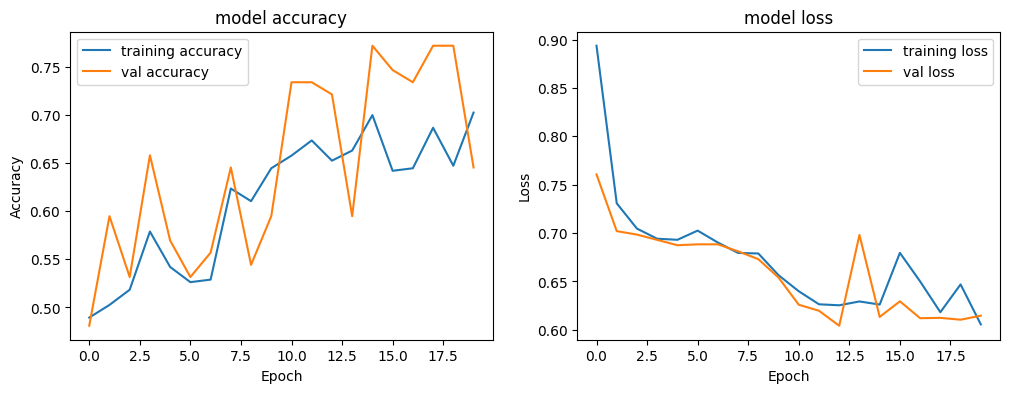

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
最佳閾值: 0.6900424957275391
混淆矩陣：
 [[36  3]
 [ 8 34]]
分類報告：
               precision    recall  f1-score   support

           0       0.82      0.92      0.87        39
           1       0.92      0.81      0.86        42

    accuracy                           0.86        81
   macro avg       0.87      0.87      0.86        81
weighted avg       0.87      0.86      0.86        81



In [ ]:
# 設定時間步長
time_steps = 2

# 構建模型
model = Sequential()

# MLP 部分
model.add(Input(shape=(time_steps, X_train_lstm.shape[2])))  # 輸入層
model.add(Flatten())  # 這層改成 Reshape 來調整輸出形狀
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # dense_units=64
model.add(Dropout(0.3))  # dropout_rate=0.2
model.add(Reshape((time_steps, 64 // time_steps)))  # reshape 後將維度調整為 (batch_size, time_steps, 32)

# LSTM 部分
model.add(LSTM(32, return_sequences=False))  # LSTM 層

# 輸出層
model.add(Dense(1, activation='sigmoid'))  # 二分類問題

# 編譯模型
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# 訓練模型
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_lstm, y_val_lstm),
    verbose=1,
    callbacks=[callback]
)

# 評估模型
loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm)
print(f"測試集損失: {loss:.4f}, 測試集準確率: {accuracy:.4f}")

# 繪製訓練過程
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 預測
y_pred_prob = model.predict(X_test_lstm)

# 繪製 ROC 曲線並計算 AUC
fpr, tpr, thresholds = roc_curve(y_test_lstm, y_pred_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"最佳閾值: {optimal_threshold}")

# 根據最佳閾值生成預測
y_pred = (y_pred_prob >= optimal_threshold).astype(int).flatten()

# 混淆矩陣
cm = confusion_matrix(y_test_lstm, y_pred)
print("混淆矩陣：\n", cm)

# 分類報告
print("分類報告：\n", classification_report(y_test_lstm, y_pred))

模型參數調整

In [ ]:
# 定義模型函數
def create_model(learning_rate=0.01, dropout_rate=0.2):
    model = Sequential()
    model.add(Input(shape=(2, X_train_lstm.shape[2])))  # 假設 time_steps=2
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(dropout_rate))
    model.add(Reshape((2, 32)))  # 將維度調整為 (batch_size, time_steps, 32)
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 包裝模型
model = KerasClassifier(build_fn=create_model, verbose=0)

# 定義超參數搜索空間
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],      # 學習率
    'dropout_rate': [0.2, 0.3, 0.5],         # Dropout 率
    'epochs': [10, 20, 30]                   # 訓練次數 (Epochs)
}

# 定義網格搜索
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# 執行搜索
grid_result = grid.fit(X_train_lstm, y_train_lstm)

# 輸出最佳參數和對應分數
print("最佳參數:", grid_result.best_params_)
print("最佳準確率: {:.4f}".format(grid_result.best_score_))

繪製交易結果

所有交易總獲利為: 63587.98 元


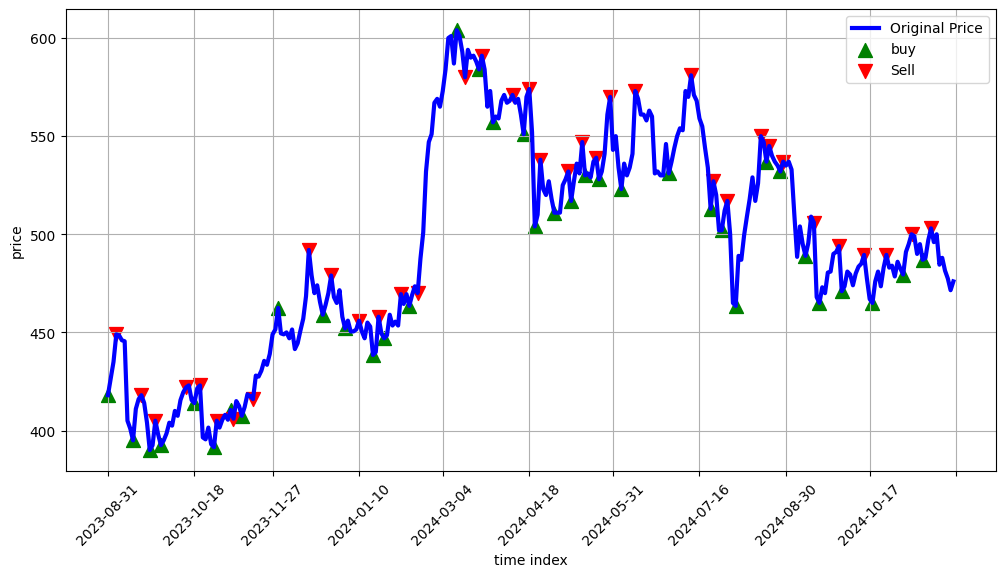

In [ ]:
total_profit = 0
buy_price = None
buy_points = []  # 買入點的時間和價格
sell_points = []  # 賣出點的時間和價格
start = 0

# 計算獲利並記錄買賣點
for i in range(len(y_pred)):
    if y_pred[i] == 1 and buy_price is None:  # 買入
        if start == 0:
          start = valid_segments[i + time_steps + train_size + val_size][1]
        buy_price = y[valid_segments[i + time_steps + train_size + val_size][1]]
        buy_points.append((valid_segments[i + time_steps + train_size + val_size][1], buy_price))
        #print(f"在時間點 {valid_segments[i + time_steps + train_size + val_size][1]} 買入，價格為 {buy_price}")

    elif y_pred[i] == 0 and buy_price is not None:  # 賣出
        sell_price = y[valid_segments[i + time_steps + train_size + val_size][1]]
        sell_points.append((valid_segments[i + time_steps + train_size + val_size][1], sell_price))
        #print(f"在時間點 {valid_segments[i + time_steps + train_size + val_size][1]} 賣出，價格為 {sell_price}")

        # 計算單次交易的成本與獲利
        quantity = 100  # 假設買賣股數固定為 100 股
        profit = calculate_stock_profit(buy_price, sell_price, quantity)
        total_profit += profit
        #print(f"此次交易獲利: {profit:.2f} 元")

        # 重置買入價格
        buy_price = None

# 總結結果
print(f"所有交易總獲利為: {total_profit:.2f} 元")

# 提取買賣點數據
buy_times, buy_prices = zip(*buy_points) if buy_points else ([], [])
sell_times, sell_prices = zip(*sell_points) if sell_points else ([], [])

date = stock.iloc[start:]['date'].reset_index(drop=True)
y_range = y[start:]

# 繪製價格折線圖和買賣點
plt.figure(figsize=(12, 6))
plt.plot(date, y_range, label='Original Price', color='blue', linewidth=3) # 繪製價格折線圖

# 買入點
buy_dates = [date.iloc[buy_time - start] for buy_time in buy_times]
plt.scatter(buy_dates, buy_prices, color='green', label='buy', marker='^', s=100)

# 賣出點
sell_dates = [date.iloc[sell_time - start] for sell_time in sell_times]
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

# 格式化 x 軸為日期
plt.gca().xaxis.set_major_locator(AutoDateLocator())  # 自動調整日期間隔

# 旋轉 x 軸標籤
plt.xticks(rotation=45)

# 添加圖例與標題
plt.xlabel('time index')
plt.ylabel('price')
plt.legend()
plt.grid(True)

# 顯示圖表
plt.show()

# LSTM 訓練結果

模型訓練

In [ ]:
# 設定時間步長
time_steps = 2  # 已經用 PLR 把資料量減少了，所以 time_steps 可以設小一點

# 構建LSTM 的輸入資料
def create_lstm_input(X, y, time_steps):
    X_lstm = []
    y_lstm = []
    for i in range(len(X) - time_steps):
        X_lstm.append(X[i:i+time_steps])
        y_lstm.append(y[i+time_steps])
    return np.array(X_lstm), np.array(y_lstm)

# 將訓練、驗證和測試資料轉換為 LSTM 格式
X_train_lstm, y_train_lstm = create_lstm_input(X_train, y_train, time_steps)
X_val_lstm, y_val_lstm = create_lstm_input(X_val, y_val, time_steps)
X_test_lstm, y_test_lstm = create_lstm_input(X_test, y_test, time_steps)

# 確認 reshape 後的資料形狀
print(f"LSTM 訓練集形狀: X_train={X_train_lstm.shape}, y_train={y_train_lstm.shape}")
print(f"LSTM 驗證集形狀: X_val={X_val_lstm.shape}, y_val={y_val_lstm.shape}")
print(f"LSTM 測試集形狀: X_test={X_test_lstm.shape}, y_test={y_test_lstm.shape}")

LSTM 訓練集形狀: X_train=(380, 2, 12), y_train=(380,)
LSTM 驗證集形狀: X_val=(79, 2, 12), y_val=(79,)
LSTM 測試集形狀: X_test=(81, 2, 12), y_test=(81,)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5215 - loss: 1.0044 - val_accuracy: 0.4810 - val_loss: 0.7717
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4731 - loss: 0.7479 - val_accuracy: 0.4810 - val_loss: 0.7021
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4507 - loss: 0.7022 - val_accuracy: 0.5190 - val_loss: 0.6975
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5201 - loss: 0.6986 - val_accuracy: 0.5190 - val_loss: 0.6946
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4720 - loss: 0.6949 - val_accuracy: 0.5190 - val_loss: 0.6929
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5175 - loss: 0.6940 - val_accuracy: 0.5190 - val_loss: 0.6927
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5266 - loss: 0.6931 - val_accuracy: 0.5190 - val_loss: 0.6923
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5206 - loss: 0.6926 - val_accuracy: 0.5190

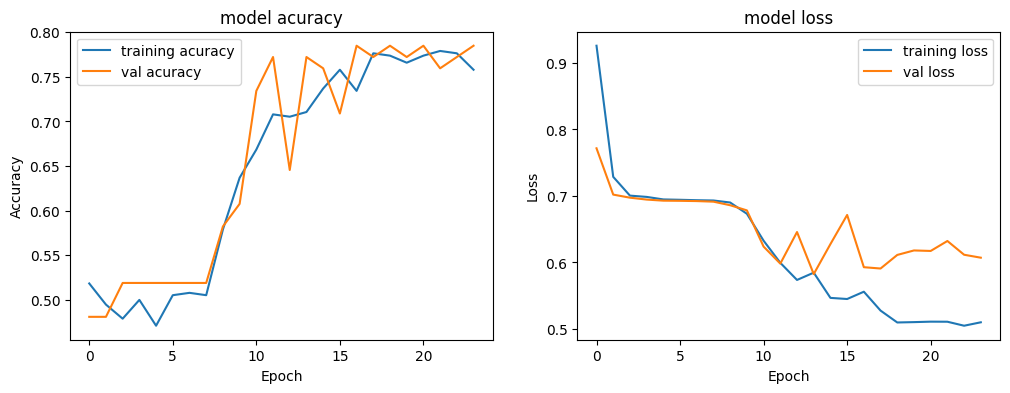

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
最佳閾值: 0.6112885475158691
混淆矩陣：
 [[36  3]
 [ 6 36]]
分類報告：
               precision    recall  f1-score   support

           0       0.86      0.92      0.89        39
           1       0.92      0.86      0.89        42

    accuracy                           0.89        81
   macro avg       0.89      0.89      0.89        81
weighted avg       0.89      0.89      0.89        81



In [ ]:
# 建立 LSTM 模型

model = Sequential()
model.add(LSTM(32, input_shape=(time_steps, X_train_lstm.shape[2]), return_sequences=False))  # lstm_units=32
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # dense_units=64
model.add(Dropout(0.2))  # dropout_rate=0.2
model.add(Dense(1, activation='sigmoid'))


# 編譯模型
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# 訓練模型
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,  # tuner/epochs
    batch_size=32,
    validation_data=(X_val_lstm, y_val_lstm),
    verbose=1,
    #class_weight=class_weights,
    callbacks=[callback]
)

# 評估模型
loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm)
print(f"測試集損失: {loss:.4f}, 測試集準確率: {accuracy:.4f}")

# 繪製訓練過程
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training acuracy')
plt.plot(history.history['val_accuracy'], label='val acuracy')
plt.title('model acuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 預測
y_pred_prob = model.predict(X_test_lstm)

# 繪製 ROC 曲線並計算 AUC
fpr, tpr, thresholds = roc_curve(y_test_lstm, y_pred_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"最佳閾值: {optimal_threshold}")

# 根據最佳閾值生成預測
y_pred = (y_pred_prob >= optimal_threshold).astype(int).flatten()

# 混淆矩陣
cm = confusion_matrix(y_test_lstm, y_pred)
print("混淆矩陣：\n", cm)

# 分類報告
print("分類報告：\n", classification_report(y_test_lstm, y_pred))

模型參數調整

In [ ]:
def build_model(hp):
    model = Sequential()

    # 添加第一層 LSTM
    model.add(LSTM(hp.Choice('lstm_units_1', [32, 64, 128]),
                   input_shape=(time_steps, X_train_lstm.shape[2]),
                   return_sequences=True))

    # 添加第二層 LSTM
    model.add(LSTM(hp.Choice('lstm_units_2', [32, 64, 128]),
                   return_sequences=False))

    # 添加第一層 Dense
    model.add(Dense(hp.Choice('dense_units_1', [32, 64, 128]), activation='relu'))
    model.add(Dropout(hp.Choice('dropout_rate_1', [0.2, 0.3, 0.4])))

    # 添加第二層 Dense
    model.add(Dense(hp.Choice('dense_units_2', [16, 32, 64]), activation='relu'))
    model.add(Dropout(hp.Choice('dropout_rate_2', [0.2, 0.3, 0.4])))

    # 輸出層
    model.add(Dense(1, activation='sigmoid'))

    # 編譯模型
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.0001])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# 創建 Hyperband 調節器
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_dir_new',
    project_name='lstm_tuning'
)

# 訓練調節器
tuner.search(X_train_lstm, y_train_lstm, validation_data=(X_val_lstm, y_val_lstm), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"最佳超參數: {best_hps.values}")

# 獲取最佳模型
best_model = tuner.get_best_models(num_models=1)[0]

繪製交易結果

所有交易總獲利為: 67848.13 元


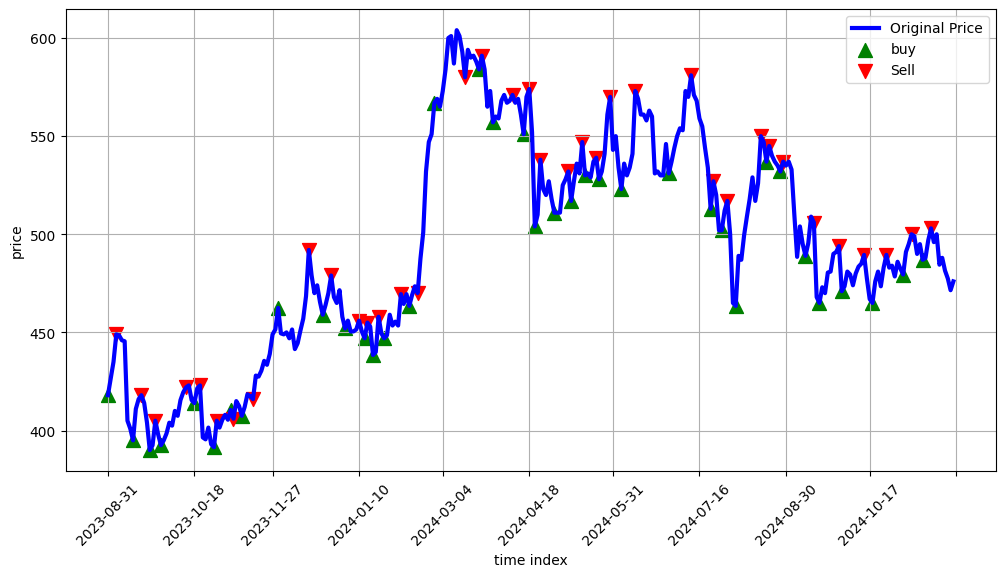

In [ ]:
total_profit = 0
buy_price = None
buy_points = []  # 買入點的時間和價格
sell_points = []  # 賣出點的時間和價格
start = 0

# 計算獲利並記錄買賣點
for i in range(len(y_pred)):
    if y_pred[i] == 1 and buy_price is None:  # 買入
        if start == 0:
          start = valid_segments[i + time_steps + train_size + val_size][1]
        buy_price = y[valid_segments[i + time_steps + train_size + val_size][1]]
        buy_points.append((valid_segments[i + time_steps + train_size + val_size][1], buy_price))
        #print(f"在時間點 {valid_segments[i + time_steps + train_size + val_size][1]} 買入，價格為 {buy_price}")

    elif y_pred[i] == 0 and buy_price is not None:  # 賣出
        sell_price = y[valid_segments[i + time_steps + train_size + val_size][1]]
        sell_points.append((valid_segments[i + time_steps + train_size + val_size][1], sell_price))
        #print(f"在時間點 {valid_segments[i + time_steps + train_size + val_size][1]} 賣出，價格為 {sell_price}")

        # 計算單次交易的成本與獲利
        quantity = 100  # 假設買賣股數固定為 100 股
        profit = calculate_stock_profit(buy_price, sell_price, quantity)
        total_profit += profit
        #print(f"此次交易獲利: {profit:.2f} 元")

        # 重置買入價格
        buy_price = None

# 總結結果
print(f"所有交易總獲利為: {total_profit:.2f} 元")

# 提取買賣點數據
buy_times, buy_prices = zip(*buy_points) if buy_points else ([], [])
sell_times, sell_prices = zip(*sell_points) if sell_points else ([], [])

date = stock.iloc[start:]['date'].reset_index(drop=True)
y_range = y[start:]

# 繪製價格折線圖和買賣點
plt.figure(figsize=(12, 6))
plt.plot(date, y_range, label='Original Price', color='blue', linewidth=3) # 繪製價格折線圖

# 買入點
buy_dates = [date.iloc[buy_time - start] for buy_time in buy_times]
plt.scatter(buy_dates, buy_prices, color='green', label='buy', marker='^', s=100)

# 賣出點
sell_dates = [date.iloc[sell_time - start] for sell_time in sell_times]
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

# 格式化 x 軸為日期
plt.gca().xaxis.set_major_locator(AutoDateLocator())  # 自動調整日期間隔

# 旋轉 x 軸標籤
plt.xticks(rotation=45)

# 添加圖例與標題
plt.xlabel('time index')
plt.ylabel('price')
plt.legend()
plt.grid(True)

# 顯示圖表
plt.show()

In [ ]:
model.save('LSTM_2379.h5')

# Logistic 訓練結果

In [ ]:
from sklearn.linear_model import LogisticRegression

# 建立邏輯回歸模型
log_reg = LogisticRegression(max_iter=500, random_state=42)

# 訓練模型
log_reg.fit(X_train, y_train)

# 預測
y_pred_val = log_reg.predict(X_val)
y_pred_test = log_reg.predict(X_test)

# 評估結果
print("驗證集分類報告：")
print(classification_report(y_val, y_pred_val))

print("測試集分類報告：")
print(classification_report(y_test, y_pred_test))

print("驗證集混淆矩陣：")
print(confusion_matrix(y_val, y_pred_val))

print("測試集混淆矩陣：")
print(confusion_matrix(y_test, y_pred_test))

In [ ]:
total_profit = 0
buy_price = None
buy_points = []  # 買入點的時間和價格
sell_points = []  # 賣出點的時間和價格
start = 0
time_steps = 2

# 計算獲利並記錄買賣點
for i in range(len(y_pred_test)):
    if i in range(time_steps):  # 考量到 LSTM 會忽略到前 time_steps 筆資料
        continue
    if start == 0:
       start = valid_segments[i + time_steps + train_size + val_size][1]

    if y_pred_test[i] == 1 and buy_price is None:  # 買入
        buy_price = y[valid_segments[i + train_size + val_size][1]]  # 股票收盤價
        buy_points.append((valid_segments[i + train_size + val_size][1], buy_price))

    elif y_pred_test[i] == 0 and buy_price is not None:  # 賣出
        sell_price = y[valid_segments[i + train_size + val_size][1]]
        sell_points.append((valid_segments[i + train_size + val_size][1], sell_price))

        # 計算單次交易的成本與獲利
        quantity = 100  # 假設買賣股數固定為 100 股
        profit = calculate_stock_profit(buy_price, sell_price, quantity)
        total_profit += profit

        # 重置買入價格
        buy_price = None

# 總結結果
print(f"所有交易總獲利為: {total_profit:.2f} 元")

# 提取買賣點數據
buy_times, buy_prices = zip(*buy_points) if buy_points else ([], [])
sell_times, sell_prices = zip(*sell_points) if sell_points else ([], [])

# 提取繪圖用的日期和價格範圍
date = stock.iloc[start:]['date'].reset_index(drop=True)
y_range = y[start:]

# 繪製價格折線圖和買賣點
plt.figure(figsize=(12, 6))
plt.plot(date, y_range, label='Original Price', color='blue', linewidth=3)  # 繪製價格折線圖

# 買入點
buy_dates = [date.iloc[buy_time - start] for buy_time in buy_times]
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)

# 賣出點
sell_dates = [date.iloc[sell_time - start] for sell_time in sell_times]
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

# 格式化 x 軸為日期
plt.gca().xaxis.set_major_locator(AutoDateLocator())  # 自動調整日期間隔

# 旋轉 x 軸標籤
plt.xticks(rotation=45)

# 添加圖例與標題
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# 顯示圖表
plt.show()

# MLP 訓練結果

驗證集分類報告：
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        39
           1       0.88      0.86      0.87        42

    accuracy                           0.86        81
   macro avg       0.86      0.86      0.86        81
weighted avg       0.86      0.86      0.86        81

測試集分類報告：
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        40
           1       0.93      0.91      0.92        43

    accuracy                           0.92        83
   macro avg       0.92      0.92      0.92        83
weighted avg       0.92      0.92      0.92        83

驗證集混淆矩陣：
[[34  5]
 [ 6 36]]
測試集混淆矩陣：
[[37  3]
 [ 4 39]]


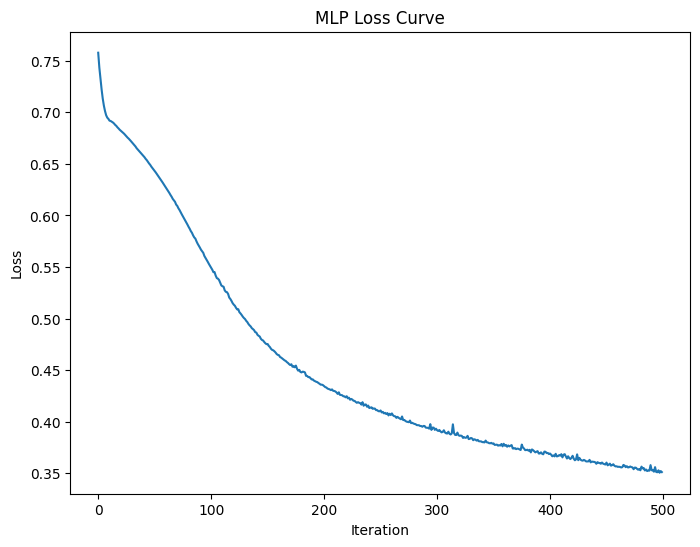

In [ ]:
# 建立 MLP 模型
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)

# 訓練模型
mlp.fit(X_train, y_train)

# 預測
y_pred_val = mlp.predict(X_val)
y_pred_test = mlp.predict(X_test)

# 評估結果
print("驗證集分類報告：")
print(classification_report(y_val, y_pred_val))

print("測試集分類報告：")
print(classification_report(y_test, y_pred_test))

print("驗證集混淆矩陣：")
print(confusion_matrix(y_val, y_pred_val))

print("測試集混淆矩陣：")
print(confusion_matrix(y_test, y_pred_test))

# 訓練過程（損失函數）
plt.figure(figsize=(8, 6))
plt.plot(mlp.loss_curve_)
plt.title('MLP Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

所有交易總獲利為: 65326.97 元


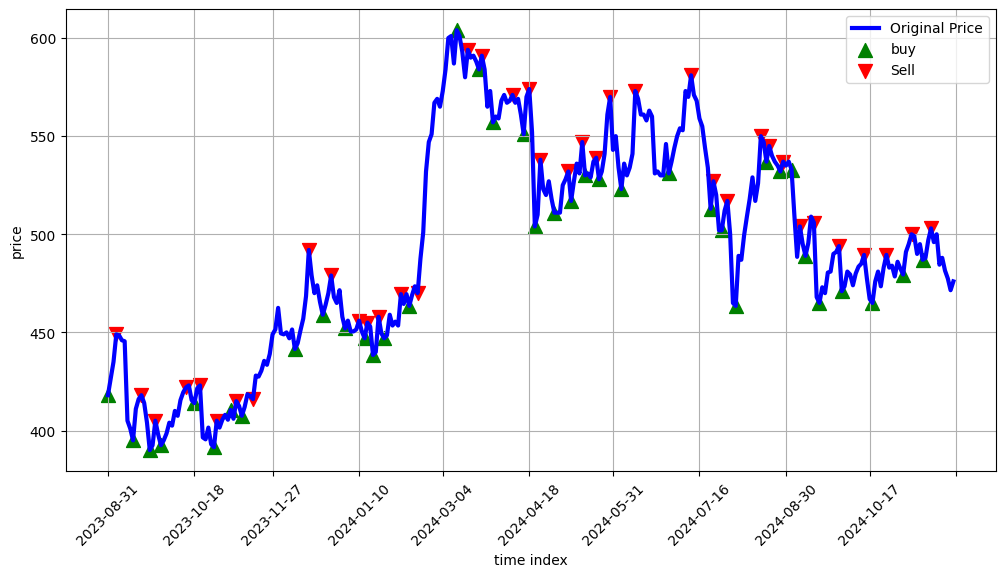

In [ ]:
total_profit = 0
buy_price = None
buy_points = []  # 買入點的時間和價格
sell_points = []  # 賣出點的時間和價格
start = 0
time_steps = 2
# 計算獲利並記錄買賣點
for i in range(len(y_pred_test)):
    if start == 0:
        start = valid_segments[i + time_steps + train_size + val_size][1]

    if i in range(time_steps): # 考量到 LSTM 會忽略到前 time_steps 筆資料，故 MLP 的獲利計算也要少算前幾筆
        continue

    if y_pred_test[i] == 1 and buy_price is None:  # 買入
        buy_price = y[valid_segments[i + train_size + val_size][1]] # 從訓練資料 + 驗證集資料後的 index 是測試集的（y: 股票收盤價）
        buy_points.append((valid_segments[i + train_size + val_size][1], buy_price))
        #print(f"在時間點 {valid_segments[i + train_size + val_size][1]} 買入，價格為 {buy_price}")

    elif y_pred_test[i] == 0 and buy_price is not None:  # 賣出
        sell_price = y[valid_segments[i  + train_size + val_size][1]]
        sell_points.append((valid_segments[i + train_size + val_size][1], sell_price))
        #print(f"在時間點 {valid_segments[i + train_size + val_size][1]} 賣出，價格為 {sell_price}")

        # 計算單次交易的成本與獲利
        quantity = 100  # 假設買賣股數固定為 100 股
        profit = calculate_stock_profit(buy_price, sell_price, quantity)
        total_profit += profit
        #print(f"此次交易獲利: {profit:.2f} 元")

        # 重置買入價格
        buy_price = None

# 總結結果
print(f"所有交易總獲利為: {total_profit:.2f} 元")

# 提取買賣點數據
buy_times, buy_prices = zip(*buy_points) if buy_points else ([], [])
sell_times, sell_prices = zip(*sell_points) if sell_points else ([], [])

date = stock.iloc[start:]['date'].reset_index(drop=True)
y_range = y[start:]

# 繪製價格折線圖和買賣點
plt.figure(figsize=(12, 6))
plt.plot(date, y_range, label='Original Price', color='blue', linewidth=3) # 繪製價格折線圖

# 買入點
buy_dates = [date.iloc[buy_time - start] for buy_time in buy_times]
plt.scatter(buy_dates, buy_prices, color='green', label='buy', marker='^', s=100)

# 賣出點
sell_dates = [date.iloc[sell_time - start] for sell_time in sell_times]
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

# 格式化 x 軸為日期
plt.gca().xaxis.set_major_locator(AutoDateLocator())  # 自動調整日期間隔

# 旋轉 x 軸標籤
plt.xticks(rotation=45)

# 添加圖例與標題
plt.xlabel('time index')
plt.ylabel('price')
plt.legend()
plt.grid(True)

# 顯示圖表
plt.show()

# MLP 找到最佳 Threshold

In [ ]:
thresholds = np.arange(0.5, 7.5, 0.5)  # 從 0.5 到 7，每次增加 0.5
results = []

for threshold in thresholds:
    print(f"正在測試 threshold = {threshold}...")
    x = np.arange(len(stock))
    y = stock['close'].values

    # 重建 PLR 樹
    root = BuildTree(x, y, 0, len(x) - 1, threshold)
    segments = []
    get_segments(root, segments)

    # 提取特徵並構建特徵矩陣
    features = []
    labels = []
    valid_segments = []

    previous_label = None  # 用於記錄前一個標籤

    for i in range(len(segments) - 1):
        start_idx, end_idx = segments[i]
        next_start_idx, next_end_idx = segments[i + 1]

        # 當前段的特徵
        x_segment = x[start_idx:end_idx + 1]
        y_segment = y[start_idx:end_idx + 1]
        volume_segment = stock['volume'].values[start_idx:end_idx + 1]

        # 計算斜率
        slope = (y_segment[-1] - y_segment[0]) / (x_segment[-1] - x_segment[0] + 1e-6)

        # 段長
        length = end_idx - start_idx

        # 中點價格
        mid_price = y_segment[len(y_segment) // 2]

        # 平均交易量
        avg_volume = np.mean(volume_segment)

        # 交易量變化
        volume_change = (volume_segment[-1] - volume_segment[0]) / (volume_segment[0] + 1e-6)

        # 技術指標
        ma_10_segment = stock['10MA'].values[start_idx:end_idx + 1]
        ma_30_segment = stock['30MA'].values[start_idx:end_idx + 1]
        rsi_segment = stock['RSI'].values[start_idx:end_idx + 1]
        macd_segment = stock['MACD'].values[start_idx:end_idx + 1]
        wmsr_segment = stock['WMS%R'].values[start_idx:end_idx + 1]

        # 技術指標特徵
        ma_10_mean = np.mean(ma_10_segment)
        ma_30_mean = np.mean(ma_30_segment)
        ma_10_std = np.std(ma_10_segment)
        ma_30_std = np.std(ma_30_segment)

        rsi_mean = np.mean(rsi_segment)
        macd_mean = np.mean(macd_segment)
        wmsr_mean = np.mean(wmsr_segment)

        # 標籤：預測下一段價格是上升（1）還是下降（0）
        next_y_segment = y[next_start_idx:next_end_idx + 1]
        price_change = next_y_segment[-1] - next_y_segment[0]

        label = -1

        if price_change > threshold:
            label = 1
        elif price_change < -threshold:
            label = 0
        elif previous_label is not None:
            label = previous_label

        if label in [0, 1]:
            features.append([
                slope, length, mid_price, avg_volume, volume_change,
                ma_10_mean, ma_30_mean, ma_10_std, ma_30_std,
                rsi_mean, macd_mean, wmsr_mean,
            ])
            labels.append(label)
            valid_segments.append(segments[i])
            previous_label = label

    # 轉換為 NumPy 數組
    X = np.array(features)
    y_labels = np.array(labels)

    n_samples = X.shape[0]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    train_size = int(n_samples * 0.7)
    val_size = int(n_samples * 0.15)
    test_size = n_samples - train_size - val_size

    X_train = X_scaled[:train_size]
    y_train = y_labels[:train_size]

    X_val = X_scaled[train_size:train_size + val_size]
    y_val = y_labels[train_size:train_size + val_size]

    X_test = X_scaled[train_size + val_size:]
    y_test = y_labels[train_size + val_size:]

    mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)

    mlp.fit(X_train, y_train)

    y_pred_test = mlp.predict(X_test)

    report = classification_report(y_test, y_pred_test, output_dict=True)
    cm = confusion_matrix(y_test, y_pred_test)

    total_profit = 0
    buy_price = None
    for i in range(len(y_pred_test)):
        if y_pred_test[i] == 1 and buy_price is None:
            buy_price = y[valid_segments[i + train_size + val_size][1]]
        elif y_pred_test[i] == 0 and buy_price is not None:
            sell_price = y[valid_segments[i + train_size + val_size][1]]
            profit = calculate_stock_profit(buy_price, sell_price, 100)
            total_profit += profit
            buy_price = None

    accuracy = report['accuracy']

    results.append({
        'threshold': threshold,
        'test_loss': 1 - accuracy,
        'test_accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_test, y_pred_test),
        'total_profit': total_profit
    })

for result in results:
    print(f"Threshold: {result['threshold']}")
    print(f"Test Loss: {result['test_loss']:.4f}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("Classification Report:")
    print(result['classification_report'])
    print(f"Total Profit: {result['total_profit']:.2f}")
    print("-" * 50)

In [ ]:
# 提取數據
thresholds = [result['threshold'] for result in results]
accuracies = [result['test_accuracy'] for result in results]
total_profits = [result['total_profit'] for result in results]

# 設置柱狀圖的寬度
bar_width = 0.4
x = np.arange(len(thresholds))

# 繪圖
fig, ax1 = plt.subplots(figsize=(10, 6))

# 右側 y 軸 - Total Profit (柱狀圖)
ax2 = ax1.twinx()
ax1.bar(x + bar_width / 2, total_profits, width=bar_width, color='orange', label='Total Profit')
ax1.set_ylabel('Total Profit', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# 左側 y 軸 - Accuracy (折線圖)
ax2.plot(x, accuracies, marker='o', color='blue', label='Accuracy', zorder=5)
ax2.set_ylabel('Accuracy', color='blue')
ax2.set_xlabel('Threshold')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{t:.1f}' for t in thresholds])

# 添加圖例
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

# 添加標題
plt.title('Threshold vs Accuracy and Total Profit')

# 顯示圖表
plt.grid(True, zorder=0)
plt.show()